# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.5.0 tensorflow-gpu==2.5.0 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
from sklearn.decomposition import PCA
def PCA_image(image): 
    bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces_pca = PCA(n_components=0.98)
    faces_pca.fit(bw)
    components = faces_pca.transform(bw)
    projected = faces_pca.inverse_transform(components)
    projected = projected.astype(np.uint8)
    projected = cv2.cvtColor(projected, cv2.COLOR_GRAY2RGB)
    return projected

In [4]:
def mediapipe_detection(image, model):
    #image = PCA_image(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
cap = cv2.VideoCapture(0)
count = 0 
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        cv2.imwrite("frame%d.jpg" % count, frame)
        count += 1
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
len(results.face_landmarks.landmark)

468

In [9]:
results

mediapipe.python.solution_base.SolutionOutputs

In [10]:
draw_landmarks(frame, results)

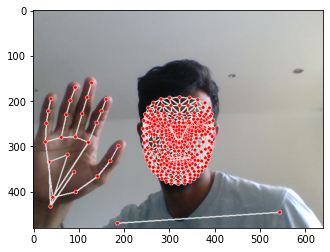

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [12]:
len(results.face_landmarks.landmark)

468

In [13]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [14]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
result_test = extract_keypoints(results)

In [17]:
result_test

array([ 0.50353462,  0.60968876, -1.01148033, ...,  0.06222065,
        0.40758187, -0.0782089 ])

In [18]:
468*3+33*4+21*3+21*3

1662

In [19]:
np.save('0', result_test)

In [20]:
np.load('0.npy')

array([ 0.50353462,  0.60968876, -1.01148033, ...,  0.06222065,
        0.40758187, -0.0782089 ])

# 4. Setup Folders for Collection

In [49]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 
# Actions that we try to detect
#actions=np.array(['after','again','also','ask', 'beautiful', 'because', 'before', 'better','big', 'bring','busy', 'but', 'buy', 'change', 'close', 'color', 'day', 'drink','easy','enough', 'fast', 'few', 'fine', 'finish', 'gone', 'goodbye', 'happy','hard','hello','help','here','how','hurt','iloveyou','improve','in','keep','know','last','later','learn','live','man','many','me','meet','more','name', 'near', 'need', 'never', 'new', 'next', 'night', 'no', 'now', 'open', 'other', 'out', 'play', 'please', 'say', 'sorry', 'thankyou', 'think','time', 'welcome', 'what', 'when', 'where', 'which', 'who', 'why', 'will', 'with','work','write','yes', 'you', 'your'])
actions = np.array(['please', 'say', 'sorry', 'thankyou', 'think','time', 'welcome', 'what', 'when', 'where','which', 'who', 'why', 'will', 'with','work','write','yes', 'you', 'your'])

# Thirty videos worth of data
no_sequences = 15

# Videos are going to be 30 frames in length
sequence_length = 30

In [50]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 6. Preprocess Data and Create Labels and Features

In [51]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [52]:
import cv2

im = cv2.imread('MP_Data/after/0/frame1.jpg')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)


<class 'numpy.ndarray'>
(480, 640, 3)


In [53]:
label_map = {label:num for num, label in enumerate(actions)}

In [54]:
label_map

{'please': 0,
 'say': 1,
 'sorry': 2,
 'thankyou': 3,
 'think': 4,
 'time': 5,
 'welcome': 6,
 'what': 7,
 'when': 8,
 'where': 9,
 'which': 10,
 'who': 11,
 'why': 12,
 'will': 13,
 'with': 14,
 'work': 15,
 'write': 16,
 'yes': 17,
 'you': 18,
 'your': 19}

In [55]:
actions.shape[0]

20

In [56]:
import pandas as pd
l=[]
for i in actions:
    for j in range(450):
        l.append(i)
y=pd.DataFrame(l)
y.shape

(9000, 1)

In [57]:
from keras.preprocessing import image
sequences = []
for action in actions:
    for sequence in range(no_sequences):
        for frame_num in range(sequence_length):
            res = image.load_img(os.path.join(DATA_PATH, action,str(sequence),"frame{}.jpg".format(frame_num)), target_size=(224, 224,3))
            img = image.img_to_array(res)
            img = img/255
            sequences.append(img)
X = np.array(sequences)
X.shape

(9000, 224, 224, 3)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.05, stratify = y)

In [59]:
X_train.shape

(8550, 224, 224, 3)

In [60]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# 7. Build and Train CNN Neural Network

In [61]:
import math
import random
import datetime as dt
import tensorflow as tf
from collections import deque
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [62]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [63]:
# Let's create a function that will construct our model
model_output_size= len(actions)
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

In [64]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [66]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = X_train, y = y_train, epochs = 15, batch_size = 4 , shuffle = True, callbacks = [early_stopping_callback])

Epoch 1/15
2138/2138 [==============================] - 714s 334ms/step - loss: 0.3116 - accuracy: 0.9022
Epoch 2/15
2138/2138 [==============================] - 713s 334ms/step - loss: 0.3065 - accuracy: 0.9032
Epoch 3/15
2138/2138 [==============================] - 738s 345ms/step - loss: 0.2965 - accuracy: 0.9064
Epoch 4/15
2138/2138 [==============================] - 758s 355ms/step - loss: 0.2581 - accuracy: 0.9135
Epoch 5/15
2138/2138 [==============================] - 751s 351ms/step - loss: 0.2617 - accuracy: 0.9167
Epoch 6/15
2138/2138 [==============================] - 711s 332ms/step - loss: 0.2423 - accuracy: 0.9250
Epoch 7/15
2138/2138 [==============================] - 902s 422ms/step - loss: 0.2341 - accuracy: 0.9267
Epoch 8/15
2138/2138 [==============================] - 1002s 469ms/step - loss: 0.2156 - accuracy: 0.9313
Epoch 9/15
2138/2138 [==============================] - 937s 438ms/step - loss: 0.2284 - accuracy: 0.9301
Epoch 10/15
2138/2138 [======================

# 8. Make Predictions

In [ ]:
#res = model.predict(X_test)

In [ ]:
#actions[np.argmax(res[1])]

In [ ]:
#actions[np.argmax(y_test[2])]

# 9. Save Weights

In [67]:
model.save('CNN.h5')

In [ ]:
#del model

In [ ]:
#model.load_weights('LSTM_2.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [68]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [69]:
yhat = model.predict(X_test)

In [70]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

ValueError: Shape of passed values is (450, 1), indices imply (450, 20)

In [71]:
multilabel_confusion_matrix(ytrue, yhat)

NameError: name 'ytrue' is not defined

In [ ]:
accuracy_score(ytrue, yhat)